# Criação de modelo baseline p/ identificação de discurso de ódio

[Voltar ao Índice](../00_indice.ipynb)

Vamos criar um modelo de identificação básico, bag of words, para servir de referência para a performance obtida com o BERT pré-treinado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import xavy.explore as xe
import xavy.dataframes as xd
import xavy.utils as xu
import xavy.text as xt
import xavy.mltools as ml

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Funções

In [2]:
def read_offcombr(path):
    """
    Load an ARFF file from OffComBR project 
    by reading it as a CSV file. The CSV 
    parameters are tuned and hard-coded for
    the project's data.

    Returns a DataFrame
    """
    df = pd.read_csv(path, skiprows=8, names=['label','sentence'], quotechar="'")
    return df

## Carregando os dados

Fontes: <https://github.com/paulafortuna/Portuguese-Hate-Speech-Dataset> e <https://github.com/rogersdepelle/OffComBR>

In [3]:
# Carrega dados da Paula Fortuna:
binhate_df = pd.read_csv('../../dados/brutos/Portuguese-Hate-Speech-Dataset/2019-05-28_portuguese_hate_speech_binary_classification.csv')

In [4]:
# Construindo base mais rigorosa:

annotations = ['hatespeech_G1', 'hatespeech_G2', 'hatespeech_G3']

assert binhate_df.query('hatespeech_comb == 0')[annotations].sum(axis=1).max() == 1
binhate_df.loc[binhate_df['hatespeech_comb'] == 0, 'label'] = 0
binhate_df.loc[binhate_df[annotations].sum(axis=1) > 2.5, 'label'] = 1

xclass_df = binhate_df.loc[~binhate_df['label'].isnull()].copy()
xclass_df['label'] = xclass_df['label'].astype(int)
xclass_df = xclass_df[['label', 'text']]

In [5]:
# Carrega dados do Pelle:
offcombr_df = read_offcombr('../../dados/brutos/OffComBR/OffComBR2.arff')
offcombr_df.rename({'sentence':'text'}, axis=1, inplace=True)
offcombr_df['label'] = offcombr_df['label'].map({'yes':1, 'no':0})

In [6]:
# Junta as bases:
mass_df = pd.concat([xclass_df, offcombr_df], ignore_index=True)

In [7]:
# Salva resultado:
#mass_df.to_csv('../../dados/processados/hatespeech_fortuna3+offcombr2.csv', index=False)

### Separando em amostras

In [8]:
# Seleciona a base de dados:
#data_df = binhate_df
data_df = mass_df
X_col = 'text'
#y_col = 'hatespeech_comb'
y_col = 'label'

# Divide em treino e teste:
train_df, test_df = ml.random_set_split(data_df, [0.8, 0.20], 876409)
X_train, y_train = ml.Xy_split(train_df[[X_col, y_col]], y_col)
X_train = X_train[X_col]
X_test,  y_test  = ml.Xy_split(test_df[[X_col, y_col]], y_col)
X_test  = X_test[X_col]

## Modelo de chute aleatório

Como ponto zero de performance, vamos utilizar um "modelo" que chuta qualquer categoria de maneira aleatória.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from xavy.mltools import geomean_hit_rate

In [12]:
random_model = ml.RandomPicker()
random_model.fit(X_train, y_train)
y_test_pred = random_model.predict(X_test)

scorers = {'acc': accuracy_score, 'f1': f1_score, 'prec':precision_score, 'rec': recall_score, 'ghr': geomean_hit_rate}
for k, v, in scorers.items():
    x = v(y_test, y_test_pred)
    print('{}: {:.3f}'.format(k, x))

acc: 0.492
f1: 0.218
prec: 0.146
rec: 0.432
ghr: 0.467


## Treinando o modelo

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Construindo o modelo

In [14]:
stopwords = xt.return_pt_stopwords()

In [15]:
vec = CountVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,1), max_df=1.0, min_df=2, binary=False)
#fit1 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features='sqrt', n_jobs=1, class_weight={1:2.5,0:1})
#fit2 = LogisticRegression(C=0.6, max_iter=10000)
#fit3 = SVC(kernel='rbf', C=3)
#fit4 = SVC(kernel='sigmoid', C=3)
#fit5 = MultinomialNB(alpha=3)
fit1 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features='sqrt', n_jobs=1, class_weight={1:1.5,0:1})
fit2 = LogisticRegression(C=3.0, max_iter=10000)
fit3 = SVC(kernel='rbf', C=3)
fit4 = SVC(kernel='sigmoid', C=6)
fit5 = MultinomialNB(alpha=0.1)
fit = VotingClassifier([('rf', fit1), ('lr', fit2), ('rbf', fit3), ('sig', fit4), ('nb', fit5)], weights=[0.34749828, 0.20278123, 0.36855106, 0.0751048 , 0.00606463])
model = Pipeline([('vec', vec), ('fit', fit)])

#### Grid search p/ os modelos constituintes

In [43]:
def fit_n_plot_grid(vec, fit, param_grid, X_train, y_train):
    
    model = Pipeline([('vec', vec), ('fit', fit)])
    grid  = GridSearchCV(model, param_grid, scoring='f1', n_jobs=6, refit=False, return_train_score=True)
    dump  = grid.fit(X_train, y_train)
    ml.plot_pars_scores(grid)

/home/skems/prog/my-python/xavy/mltools.py:1870: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/skems/prog/my-python/xavy/mltools.py:1870: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/skems/prog/my-python/xavy/mltools.py:1870: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/skems/prog/my-python/xavy/mltools.py:1870: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/skems/prog/my-python/xavy/mltools.py:1870: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


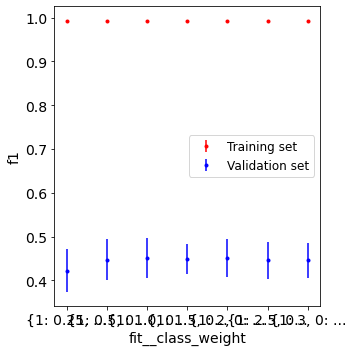

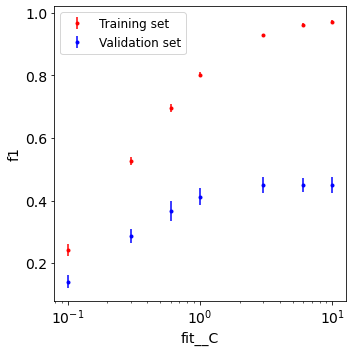

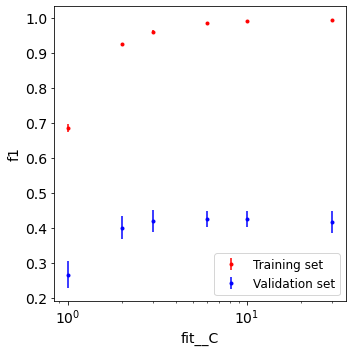

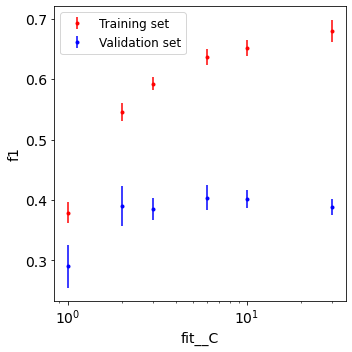

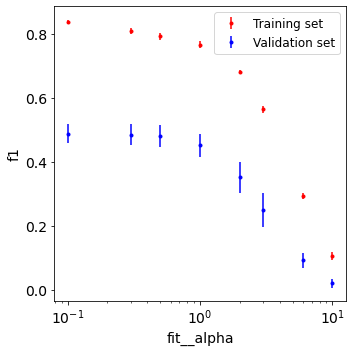

In [45]:
fitters = [fit1, fit2, fit3, fit4, fit5]
params  = [{'fit__class_weight': [{1:0.25, 0:1}, {1:0.5, 0:1}, {1:1.0, 0:1}, {1:1.5, 0:1}, {1:2,0:1}, {1:2.5,0:1}, {1:3,0:1}]}, 
           {'fit__C': [0.1, 0.3, 0.6, 1.0, 3.0, 6.0, 10.]},
           {'fit__C': [1.0, 2.0, 3.0, 6.0, 10., 30.]},
           {'fit__C': [1.0, 2.0, 3.0, 6.0, 10., 30.]},
           {'fit__alpha': [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 6.0, 10.]}]
for f, p in zip(fitters, params):
    fit_n_plot_grid(vec, f, p, X_train, y_train)

#### Processo iterativo de definição dos pesos dos votos

In [52]:
#vote_weights = [np.random.rand(4) * 2 for _ in range(40)]
expected_weights = np.array([0.35721117, 0.19877604, 0.36376866, 0.07514268, 0.00510145])
vote_weights = [np.random.normal(loc=expected_weights, scale=expected_weights/7) for _ in range(10)]

In [53]:
param_grid = {#'vec__lowercase': [True, False],
              #'vec__ngram_range': [(1,1), (1,2)],
              #'vec__min_df': [1, 2, 4],
              #'vec__binary': [True, False],
              #'vec__stop_words': [None, stopwords],
              #'fit__alpha': [ 1, 3., 10],
              #'fit__fit_prior':[True, False],
              #'fit__kernel':['poly', 'rbf', 'sigmoid'],
              #'fit__degree':[1,2,3],
              #'fit__gamma': [0.03, 0.06, 0.10],
              #'fit__coef0': [0, 0.3, 1.0],
              #'fit__C': [1.0, 3.0, 10.],
              'fit__weights':vote_weights
              #'fit__max_depth': [6, 12, 20, 30, 60, 120], 
              #'fit__min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16], 
              #'fit__class_weight': [{1:1,0:1}, {1:1.7,0:1}, {1:2,0:1}, {1:2.5,0:1}]
}
grid = GridSearchCV(model, param_grid, scoring='f1', n_jobs=6, refit=False, return_train_score=True)

In [54]:
dump = grid.fit(X_train, y_train)

In [56]:
opt_df = ml.searchCV_table(grid)
opt_sorted_weights = opt_df['param_fit__weights']
opt_sorted_weights = opt_sorted_weights / opt_sorted_weights.apply(np.sum)
opt_sorted_weights.iloc[0]

array([0.41812817, 0.17667293, 0.31970775, 0.08043857, 0.00505258])

In [55]:
opt_df.head()

,mean_fit_time,std_fit_time,param_fit__weights,mean_test_score,std_test_score,mean_train_score,std_train_score
2,4.728621,0.213147,"[0.3770664285127322, 0.20982483284457193, 0.38...",0.452302,0.033394,0.962968,0.004226
6,4.885858,0.450524,"[0.34436304756218, 0.2092490409194602, 0.30664...",0.451564,0.029378,0.962968,0.004226
7,4.872835,0.249019,"[0.36816434803045317, 0.26342453463375154, 0.4...",0.450655,0.034714,0.962968,0.004226
0,4.268393,0.236665,"[0.2934024382517492, 0.25971538729825466, 0.43...",0.450534,0.033331,0.962968,0.004226
4,4.684539,0.410770,"[0.4954680189852425, 0.24545654681841841, 0.37...",0.449602,0.031880,0.962968,0.004226


In [ ]:
pl.plot(opt_df['mean_test_score'].iloc[:35].values)
pl.show()

#### Avaliação do  modelo

In [58]:
np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy'))

0.8643295445337419

In [57]:
np.mean(cross_val_score(model, X_train, y_train, scoring='f1'))

0.4550657092948434

In [59]:
np.mean(cross_val_score(model, X_train, y_train, scoring='precision'))

0.6777159139982099

In [60]:
np.mean(cross_val_score(model, X_train, y_train, scoring='recall'))

0.3386631598040994

## Learning curve

In [ ]:
ml.plot_learning_curve(model, X_train, y_train, 'accuracy')
pl.show()

In [ ]:
ml.plot_learning_curve(model, X_train, y_train, 'accuracy')
#pl.ylim([0.7, 0.8])
pl.ylim([0.8, 0.9])
pl.show()

### Avaliação na amostra de teste

In [20]:
dump = model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8696808510638298

In [17]:
confusion_matrix(y_test, y_test_pred)

array([[916,  27],
       [121,  64]])

In [21]:
scorers = {'acc': accuracy_score, 'f1': f1_score, 'prec':precision_score, 'rec': recall_score, 'gmr': geomean_hit_rate}
for k, v, in scorers.items():
    x = v(y_test, y_test_pred)
    print('{}: {:.3f}'.format(k, x))

acc: 0.870
f1: 0.469
prec: 0.707
rec: 0.351
gmr: 0.584


**Resultados**

* A avaliação na amostra de teste para os dados binários da Paula Fortuna (exemplos selecionados com dois dos três anotadores concordando):
    * Accuracy: 0.75
    * F1: 0.51
* A avaliação na amostra de teste para os dados combinados de Paula e Pelle:
    * Accuracy: 0.87
    * F1: 0.47